The Sign Language MNIST dataset offers a challenging alternative to the classic MNIST dataset, focusing on 24 American Sign Language (ASL) hand gestures, excluding 'J' and 'Z' due to their motion requirements. It mirrors the original MNIST structure, with 28x28 grayscale images flattened into rows, but presents added complexity due to gesture variations and inter-class similarity.
___

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

Mounted at /content/drive


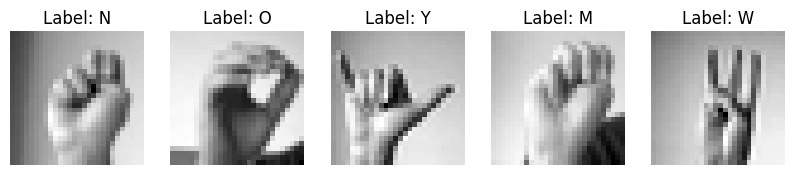

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt


drive.mount('/content/drive')

# Load the dataset
train_data_path = "/content/drive/MyDrive/Datasets/Sign_Language_MNIST/sign_mnist_train.csv"  # Replace with the path to the training dataset CSV file
test_data_path = "/content/drive/MyDrive/Datasets/Sign_Language_MNIST/sign_mnist_test.csv"    # Replace with the path to the test dataset CSV file

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Separate labels and pixel values
train_labels = train_data.iloc[:, 0].values  # First column contains the labels
train_images = train_data.iloc[:, 1:].values  # Remaining columns contain the pixel values

# Normalize the pixel values (optional but recommended)
train_images = train_images / 255.0

# Visualize random images
def plot_random_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        idx = np.random.randint(0, len(images))  # Pick a random image
        image = images[idx].reshape(28, 28)  # Reshape to 28x28
        label = labels[idx]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {chr(label + 65)}")  # Convert label (0-25) to letter (A-Z)
        plt.axis('off')
    plt.show()

# Plot 5 random images from the training set
plot_random_images(train_images, train_labels)


In [7]:
# Overview of the dataset
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


> **Dataset Overview:**  
>The training set at approximately 80% of the complete dataset contains 27,455 instances of many image variations and 784 features (1 label column).  
_Class Labels_ are 24 integers (0-23), corresponding to letters A-Y (excluding J and Z due to their representation requiring motion).
>
>Training Data Shape:  [27,455 , 785]  
>Test Data Shape:  [7,172 , 785]  


In [3]:
miss = train_data.isnull().values.any()
print(f"Missing values: {miss}")
print("Dataset Shape:", train_data.shape)
print("Test Dataset Shape:", test_data.shape)
print("Unique Labels:", train_data['label'].nunique())

Missing values: False
Dataset Shape: (27455, 785)
Test Dataset Shape: (7172, 785)
Unique Labels: 24


> Pixel Values:
Here we make inferences with the pixel values such as _Mean Intensity_ (145-1656), and _STD Intensity_ (31-65). A range of 0-255 indicates _grayscale images_. Values are normalized to the range [0, 1] for training.

In [4]:
# Summary of pixel values
pixel_summary = train_data.iloc[:, 1:].describe()
pixel_summary


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,165.533673,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,31.279244,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,148.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,167.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,186.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


> The Distribution here is relatively balanced with slight variations across classes

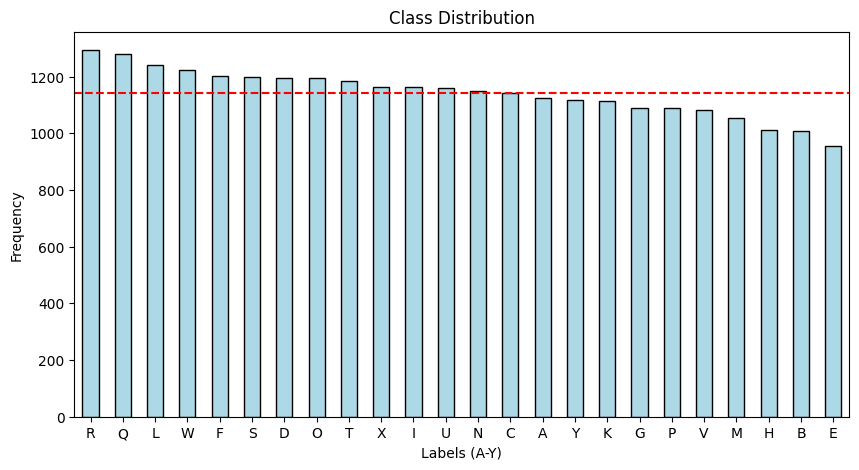

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Check for class distribution
class_distribution = train_data['label'].value_counts()

# Convert labels to letters (A-Z)
class_distribution.index = class_distribution.index.map(lambda x: chr(x + 65))

# Visualize the class distribution
class_distribution.plot(kind='bar', figsize=(10, 5), color='lightblue', edgecolor='black', title='Class Distribution')
plt.xlabel('Labels (A-Y)')
plt.axhline(y=class_distribution.mean(), color='red', linestyle='--', label='Mean Count')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()


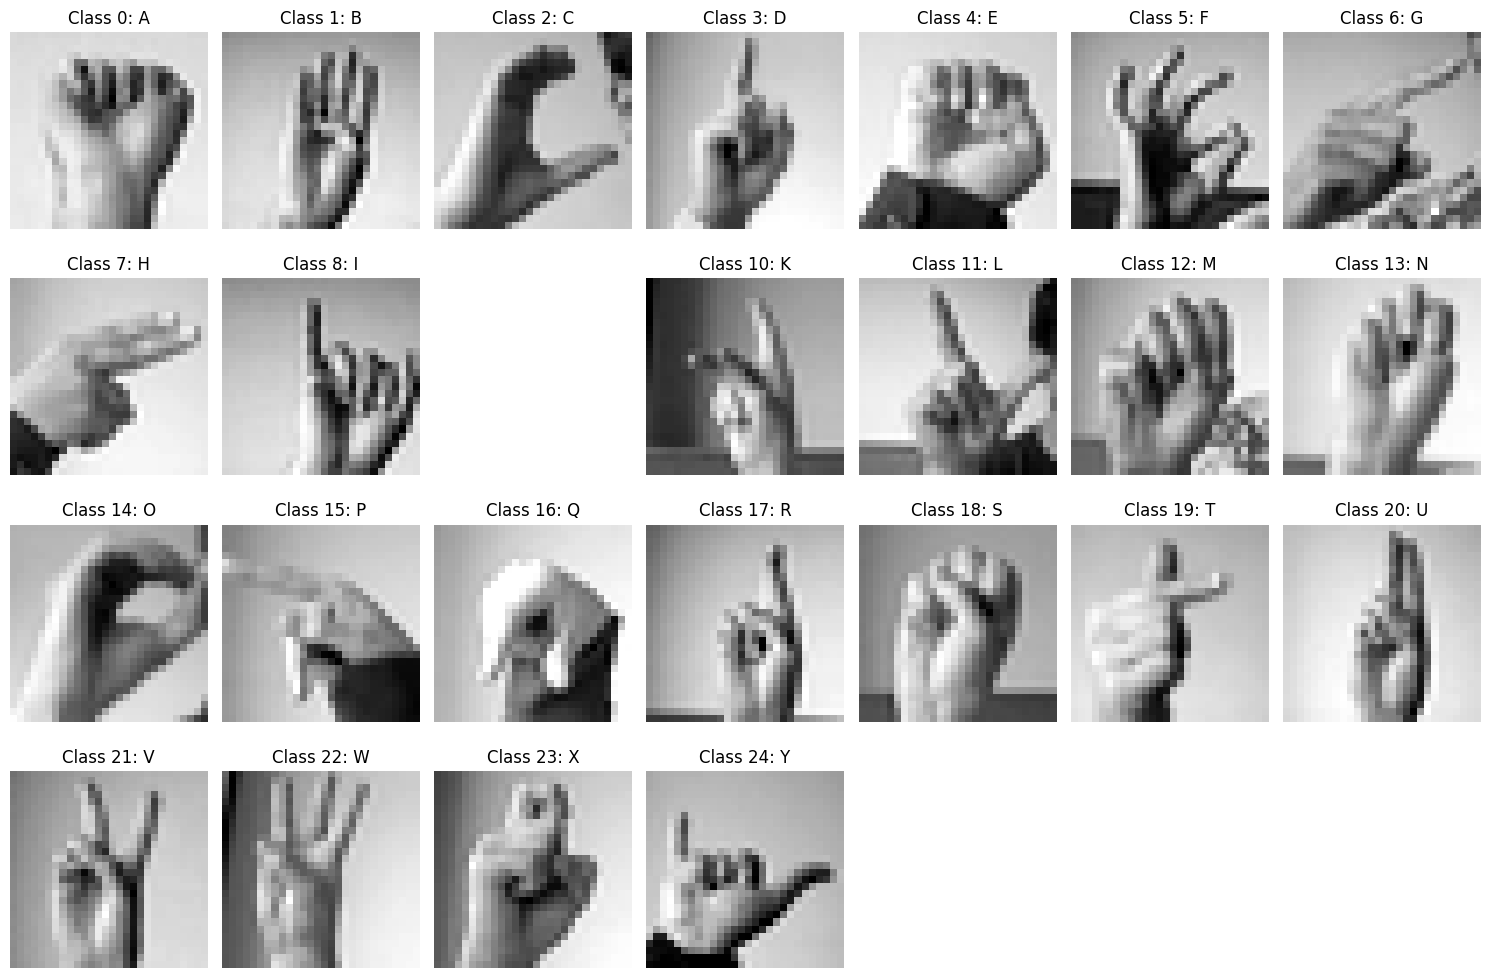

In [6]:
def plot_all_classes(images, labels):
    plt.figure(figsize=(15, 10))
    for label in range(26):  # Iterate over labels 0–25
        if label in labels:
            idx = np.where(labels == label)[0][0]  # Get the first occurrence of each label
            image = images[idx].reshape(28, 28)
            plt.subplot(4, 7, label + 1)  # 4 rows x 7 columns for 26 letters
            plt.imshow(image, cmap='gray')
            plt.title(f"Class {label}: {chr(label + 65)}")  # Show class number and letter
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot one image for each class (A-Z)
plot_all_classes(train_images, train_labels)



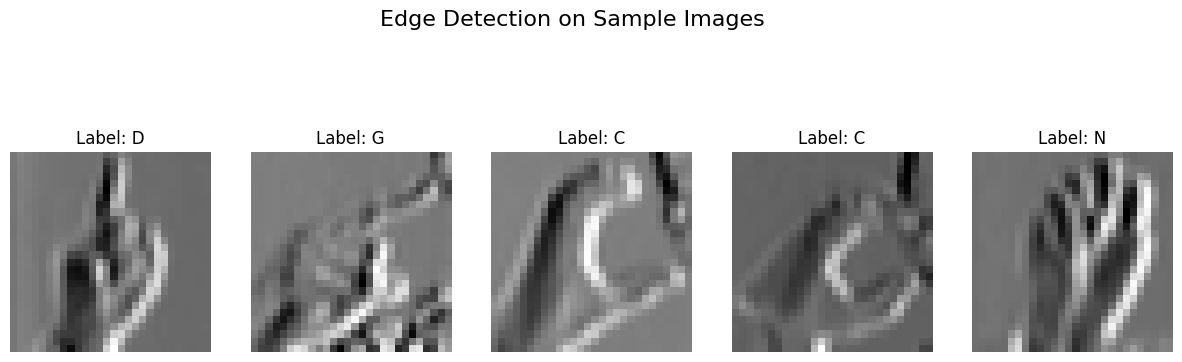

In [7]:
from scipy.ndimage import sobel

sample_images = train_images[:5]
plt.figure(figsize=(15, 5))
for i, image in enumerate(sample_images):
    image_reshaped = image.reshape(28, 28)
    edge_image = sobel(image_reshaped)
    plt.subplot(1, 5, i + 1)
    plt.imshow(edge_image, cmap='gray')
    plt.title(f'Label: {chr(train_labels[i] + 65)}')
    plt.axis('off')
plt.suptitle('Edge Detection on Sample Images', fontsize=16)
plt.show()


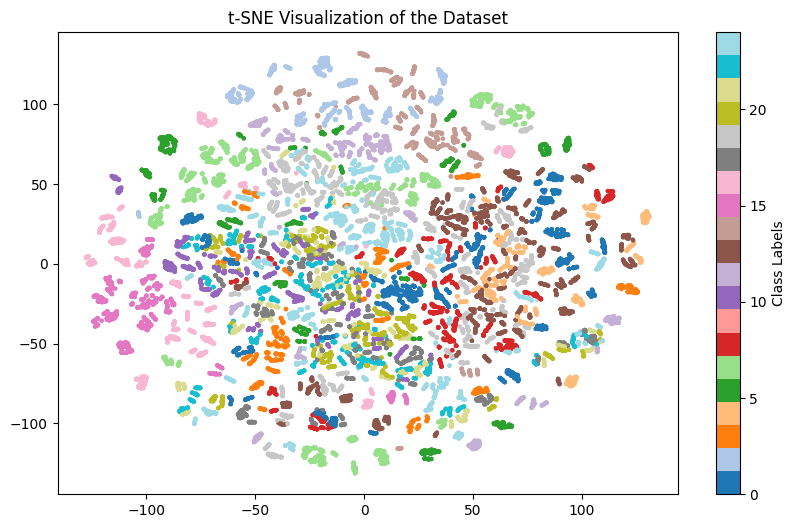

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=50).fit_transform(train_images)  # Reduce to 50 dimensions
tsne = TSNE(n_components=2, random_state=42).fit_transform(pca)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=train_labels, cmap='tab20', s=5)
plt.colorbar(scatter, label='Class Labels')
plt.title('t-SNE Visualization of the Dataset')
plt.show()


In [21]:
# Define constants for data handling
BATCH_SIZE = 32
IMG_HEIGHT = 96
IMG_WIDTH = 96
NUM_CLASSES = 26

# Create tf.data.Dataset for Training and Test Data
def preprocess_image(image, label):
    # Reshape to 28x28 and add channel dimension
    image = tf.reshape(image, [28, 28, 1])
    # Resize to 96x96
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Convert grayscale (1 channel) to RGB (3 channels)
    image = tf.image.grayscale_to_rgb(image)
    # Normalize pixel values
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def load_dataset_from_dataframe(dataframe):
    # Extract features and labels
    labels = dataframe.iloc[:, 0].values
    images = dataframe.iloc[:, 1:].values

    # Convert labels to one-hot encoding
    labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    dataset = dataset.map(preprocess_image)
    dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [22]:
# Prepare training, validation, and test datasets
train_val_split = int(len(train_data) * 0.9)
train_df = train_data.iloc[:train_val_split]
val_df = train_data.iloc[train_val_split:]

train_dataset = load_dataset_from_dataframe(train_df)
val_dataset = load_dataset_from_dataframe(val_df)
test_dataset = load_dataset_from_dataframe(test_data)

In [23]:
from tensorflow.keras import layers

# Define the data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),       # Rotate +/- 10%
    layers.RandomBrightness(0.1)      # Change brightness
])

# Function to apply data augmentation
def augment_dataset(dataset):
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                       num_parallel_calls=tf.data.AUTOTUNE)

# Apply data augmentation only to the training dataset
train_dataset = augment_dataset(train_dataset)

In [24]:
def create_model(img_height, img_width, num_classes, dense_size=256, dropout_rate=0.5):

    # Load the base MobileNetV3 model with ImageNet weights
    base_model = MobileNetV3Small(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

    # Define the model architecture
    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(dropout_rate)(x)  # Add dropout for regularization
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and return the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [26]:
LR = 0.00001
DROPOUT = 0.5
DENSE_SIZE = 256

In [27]:
# Build the best model

model = create_model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, dense_size=DENSE_SIZE, dropout_rate=DROPOUT)
model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 3, 3, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,093,514 (4.17 MB)

 Trainable params: 1,081,402 (4.13 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [29]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 104s 80ms/step - accuracy: 0.0444 - loss: 3.8156 - val_accuracy: 0.0528 - val_loss: 3.4352
Epoch 2/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.0460 - loss: 3.3394 - val_accuracy: 0.0437 - val_loss: 3.3424
Epoch 3/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.0488 - loss: 3.2556 - val_accuracy: 0.0306 - val_loss: 3.2731
Epoch 4/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.0565 - loss: 3.2135 - val_accuracy: 0.0503 - val_loss: 3.3236
Epoch 5/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.0616 - loss: 3.1908 - val_accuracy: 0.0382 - val_loss: 3.2510
Epoch 6/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.0687 - loss: 3.1569 - val_accuracy: 0.0750 - val_loss: 3.1301
Epoch 7/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.0796 - loss: 3.1126 - val_accuracy: 0.0783 - val_loss: 3.0806
Epoch 8/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - accuracy: 0.0885 - loss: 3.0554 -

Test Accuracy: 50.52%


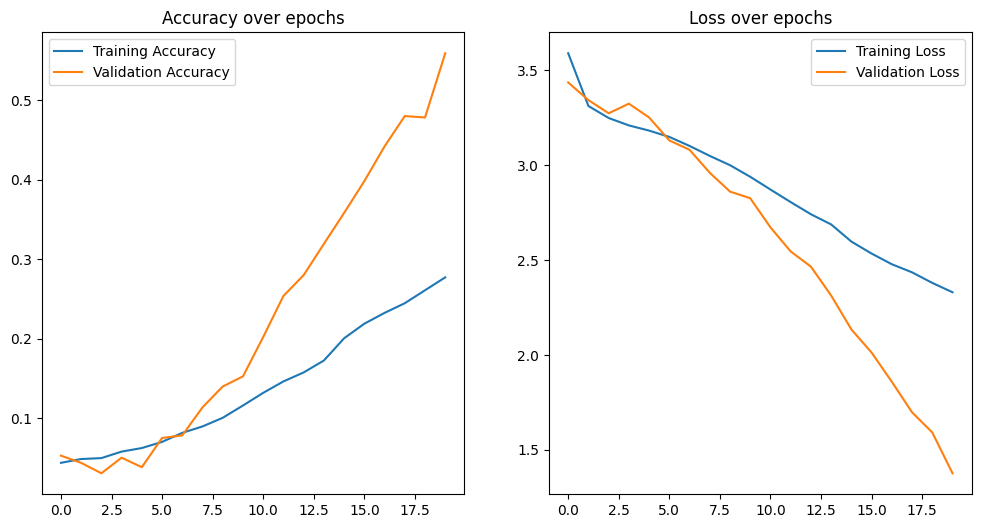

In [32]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Separate features (pixels) and labels (class)
X_train = train_data.drop(columns='label').values
y_train = train_data['label'].values
X_test = test_data.drop(columns='label').values
y_test = test_data['label'].values

# Reshape data into 32x32x3 images (RGB)
X_train = X_train.reshape(-1, 28, 28, 1)  # Assuming original images are 28x28 grayscale
X_test = X_test.reshape(-1, 28, 28, 1)
X_train = tf.image.resize(X_train, [32, 32])  # Resize to 32x32
X_test = tf.image.resize(X_test, [32, 32])
X_train = tf.image.grayscale_to_rgb(X_train)  # Convert to RGB
X_test = tf.image.grayscale_to_rgb(X_test)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert X_train and X_test to NumPy arrays
X_train = X_train.numpy()
X_test = X_test.numpy()

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=25)  # 24 classes
y_test = to_categorical(y_test, num_classes=25)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Define data augmentation parameters for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the image
    rotation_range=3,  # Rotate by up to 3 degrees
    width_shift_range=0.1,  # Randomly shift horizontally
    height_shift_range=0.1,  # Randomly shift vertically
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # How to fill in newly created pixels during transformations
)

#NOTE: Adding Data Augmentation here does improve model accuracy! Data Augmentation is not overkill. Inferences can be made. (J.Long)



# Apply data augmentation on training data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# If validation data augmentation is not needed (you want to preserve the original validation data):
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Build the MobileNetV3Small model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model
base_model.trainable = False


# Create the custom top layers
inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)


x = Dense(2048, activation='swish')(x)  # Larger dense layer
x = Dropout(0.4)(x)  # More dropout to combat overfitting
x = Dense(1024, activation='swish')(x)  # Add more layers
x = Dropout(0.2)(x)
x = Dense(25, activation='softmax')(x)  # 24 classes for ASL gestures

# Final model
model = Model(inputs, x)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 1, 1, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2048)                │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25)                  │          25,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,244,617 (16.19 MB)

 Trainable params: 3,305,497 (12.61 MB)

 Non-trainable params: 939,120 (3.58 MB)

Epoch 1/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.0518 - loss: 3.3098 - val_accuracy: 0.0943 - val_loss: 3.0042
Epoch 2/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.0967 - loss: 2.9749 - val_accuracy: 0.0934 - val_loss: 2.8917
Epoch 3/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1174 - loss: 2.8191 - val_accuracy: 0.1448 - val_loss: 2.6643
Epoch 4/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1344 - loss: 2.7411 - val_accuracy: 0.1610 - val_loss: 2.6145
Epoch 5/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1465 - loss: 2.6733 - val_accuracy: 0.1561 - val_loss: 2.5688
Epoch 6/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1553 - loss: 2.6177 - val_accuracy: 0.1521 - val_loss: 2.6330
Epoch 7/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1657 - loss: 2.5812 - val_accuracy: 0.1852 - val_loss: 2.4721
Epoch 8/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1787 - loss: 2.5357 - val_accuracy

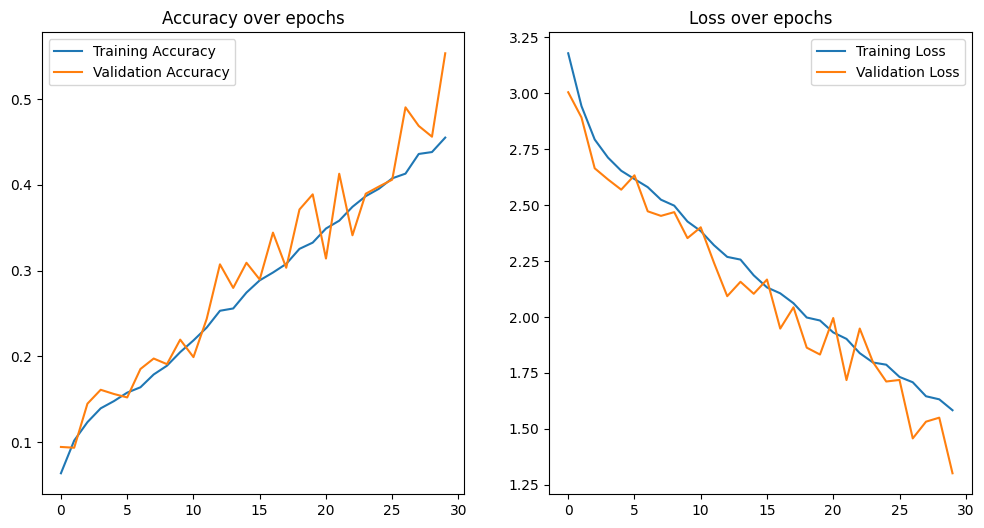

In [34]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()

In [ ]:
# Plot Training History
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
!jupyter nbconvert --to pdf